In [0]:
from IPython.display import clear_output
!pip install --upgrade tensorflow-gpu
!pip install --upgrade tqdm
clear_output()

In [0]:
#Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

## Data Download

In [0]:
#Downloads and extract Dataset to local, wait for download, i dont want to put a progress bar here sorry
#You can run this on google colab for get faster downloads speeds
import os
import tarfile
import requests
from tqdm import tqdm

folder_path = "./Datasets"

wiki_url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar"
wiki_path = folder_path + '/wiki.tar.gz'

imdb_url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar"
imdb_path = folder_path + '/imdb.tar.gz'

if(not os.path.exists(folder_path)):
  os.mkdir(folder_path)

if(not(os.path.exists(wiki_path) and os.path.isfile(wiki_path))):
  resp = requests.get(wiki_url, stream=True)

  total_size = int(resp.headers.get('content-length', 0))
  block_size = 16384
  t=tqdm(total=total_size, unit='iB', unit_scale=True)
  
  with open(wiki_path, "wb") as f:
    for data in resp.iter_content(block_size):
      t.update(len(data))
      f.write(data)
    t.close()
    f.close()

    if total_size != 0 and t.n != total_size:
      print("Wiki Faces Download Error")

  tar = tarfile.open(wiki_path, "r")
  tar.extractall(folder_path)
  tar.close()

  os.remove("./Datasets/wiki_crop/wiki.mat")



if(not(os.path.exists(imdb_path) and os.path.isfile(imdb_path))):
  resp = requests.get(imdb_url, stream=True)

  total_size = int(resp.headers.get('content-length', 0))
  block_size = 16384
  t=tqdm(total=total_size, unit='iB', unit_scale=True)
  
  with open(imdb_path, "wb") as f:
    for data in resp.iter_content(block_size):
      t.update(len(data))
      f.write(data)
    t.close()
    f.close()

    if total_size != 0 and t.n != total_size:
      print("Imdb Faces Download Error")

  tar = tarfile.open(imdb_path, "r")
  tar.extractall(folder_path)
  tar.close()

  os.remove("./Datasets/imdb_crop/imdb.mat")

In [0]:
root = "./Datasets"
folders = os.listdir(root)

if(not ("dataset.csv" in folders)):
  folders.remove("imdb.tar.gz")
  folders.remove("wiki.tar.gz")

  data = list()

  for folder in folders:
    subfolders = os.listdir("{root}/{folder}".format(root=root, folder=folder))
    for subfolder in subfolders:
      files = os.listdir("{root}/{folder}/{subfolder}".format(root=root, folder=folder, subfolder=subfolder))
      for file in files:
        path = "{root}/{folder}/{subfolder}/{file}".format(root=root, folder=folder, subfolder=subfolder, file=file)

        try:
          file_data = file[:-4]
          file_data = file_data.split("_")

          if(folder == "wiki_crop"):
            id = "w" + file_data[0]
            born = int(file_data[1].split("-")[0])
          else:
            id = "i" + file_data[0][2:]
            born = int(file_data[2].split("-")[0])

          taken = int(file_data[-1])
          age = taken - born

          data.append([id, age, path])
        except:
          print("error")
          

  df = pd.DataFrame(data=data, columns=["personId", "age", "url"])
  df.to_csv(root + "/dataset.csv", index=False)

## Exploratory Data analysis and Cleaning

In [5]:
#Load csv
faces_df = pd.read_csv("./Datasets/dataset.csv")
faces_df.head()

,personId,age,url
0,w23800897,27,./Datasets/wiki_crop/97/23800897_1940-11-03_19...
1,w34734897,22,./Datasets/wiki_crop/97/34734897_1993-12-31_20...
2,w43978497,20,./Datasets/wiki_crop/97/43978497_1959-09-01_19...
3,w6732297,23,./Datasets/wiki_crop/97/6732297_1985-09-30_200...
4,w2461597,28,./Datasets/wiki_crop/97/2461597_1981-07-28_200...


In [6]:
faces_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523051 entries, 0 to 523050
Data columns (total 3 columns):
personId    523051 non-null object
age         523051 non-null int64
url         523051 non-null object
dtypes: int64(1), object(2)
memory usage: 12.0+ MB


In [7]:
#Check descriptive statistics
faces_df.describe()

,age
count,523051.000000
mean,37.393522
std,34.341813
min,-74.000000
25%,27.000000
50%,35.000000
75%,45.000000
max,2015.000000


High Precense of outliers, lets fix that

In [8]:
#Clear Dataset from outliers
age_up_0 = faces_df["age"] > 0
age_down_75 = faces_df["age"] < 75
faces_df = faces_df[age_up_0 & age_down_75]
faces_df.describe()

,age
count,513587.000000
mean,36.354462
std,12.658490
min,1.000000
25%,27.000000
50%,35.000000
75%,44.000000
max,74.000000


In [9]:
#Check for how much unique people is here
id_count = faces_df["personId"].nunique()
"The Dataset contains {count} unique persons across its images".format(count=id_count)

'The Dataset contains 78115 unique persons across its images'

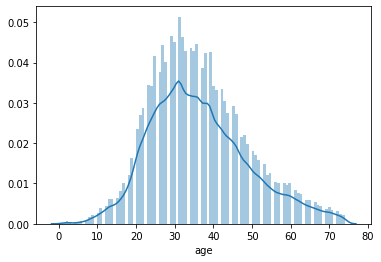

In [10]:
#Lets see the distribution of the age across our dataset
sns.distplot(faces_df["age"], bins=100)